In [1]:
# Import Library
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import np_utils
from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.utils import np_utils
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import UpSampling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
from keras.layers import Input
from keras.models import Model
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load .csv as npy
X_test = np.load('../dataset/test/X_test.npy')
Y_test = np.load('../dataset/test/Y_test.npy')
X_train = np.load('../dataset/test/X_train.npy')
Y_train = np.load('../dataset/test/Y_train.npy')
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(1000, 64, 64, 3) (1000, 3) (3000, 64, 64, 3) (3000, 3)


In [13]:
# 3D Vector -> 2D Image
X_train_2d = np.zeros((X_train.shape[0], 64, 64, 1))
for r in range(X_train.shape[0]):
    X_train_2d[r, :, :, 0] = np.resize(X_train[r], (64, 64))
X_test_2d = np.zeros((X_test.shape[0], 64, 64, 1))
for r in range(X_test.shape[0]):
    X_test_2d[r, :, :, 0] = np.resize(X_test[r], (64, 64))
print(Y_train.shape, X_train_2d.shape)
print(Y_test.shape, X_test_2d.shape)

(3000, 3) (3000, 64, 64, 1)
(1000, 3) (1000, 64, 64, 1)


In [14]:
# Feature Normalization
X_train, X_test = X_train/255., X_test/255.

In [18]:
# Build Model
model_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], X_train_2d.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(1024*4, activation='relu')(model_hidden)
model_hidden = Dense(256*4, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              33558528  
__________

In [20]:
# Optimization Method
# es = EarlyStopping(mode='auto')
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [21]:
# Train
model_history = model_cnn.fit(X_train_2d, Y_train, validation_data=(X_test_2d, Y_test), epochs=10, batch_size=256, verbose=2)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 80s - loss: 3.0395 - acc: 0.4490 - val_loss: 1.1306 - val_acc: 0.5170
Epoch 2/10
 - 31s - loss: 1.0329 - acc: 0.4673 - val_loss: 0.9512 - val_acc: 0.5170
Epoch 3/10
 - 30s - loss: 0.9605 - acc: 0.5103 - val_loss: 0.9422 - val_acc: 0.5350
Epoch 4/10
 - 31s - loss: 0.9451 - acc: 0.5177 - val_loss: 0.9232 - val_acc: 0.5430
Epoch 5/10
 - 29s - loss: 0.9329 - acc: 0.5290 - val_loss: 0.9045 - val_acc: 0.5520
Epoch 6/10
 - 27s - loss: 0.9053 - acc: 0.5603 - val_loss: 0.8921 - val_acc: 0.5560
Epoch 7/10
 - 28s - loss: 0.8819 - acc: 0.5763 - val_loss: 0.8816 - val_acc: 0.5640
Epoch 8/10
 - 27s - loss: 0.8675 - acc: 0.5780 - val_loss: 0.8799 - val_acc: 0.5540
Epoch 9/10
 - 27s - loss: 0.8563 - acc: 0.5880 - val_loss: 0.8844 - val_acc: 0.5730
Epoch 10/10
 - 27s - loss: 0.8348 - acc: 0.6097 - val_loss: 0.8654 - val_acc: 0.5750


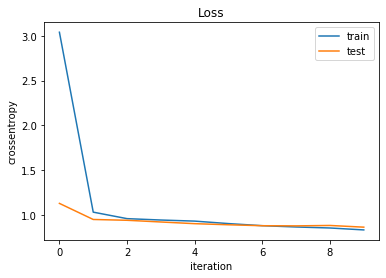

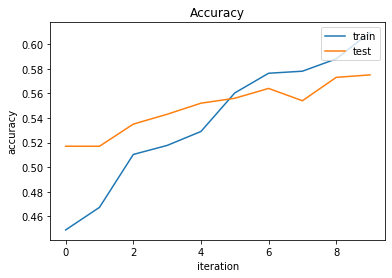

In [22]:
# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

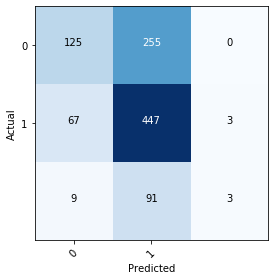

In [24]:
# Validation: Confusion Matrix Analysis
def plot_confusion_matrix(model_input, feature, label, class_info):
    pred = model_input.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(class_info))
    plt.xticks(tick_marks, class_info, rotation=45), plt.yticks(tick_marks, class_info)
    thresh = cnf_matrix.max()/2.
#     for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j], horizontalalignment='center', color='white' if cnf_matrix[i,j]>thresh else 'black')
    plt.ylabel('Actual'), plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(model_cnn, X_test_2d, Y_test, range(0, 2))

In [25]:
# Build Mode2
model_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], X_train_2d.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='sigmoid')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='sigmoid')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(256, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              8389632   
__________

In [27]:
# Optimization Method
# es = EarlyStopping(mode='auto')
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [28]:
# Train
model_history = model_cnn.fit(X_train_2d, Y_train, validation_data=(X_test_2d, Y_test), epochs=10, batch_size=256, verbose=2)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 22s - loss: 7.4042 - acc: 0.4950 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 2/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 3/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 4/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 5/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 6/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 7/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 8/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 9/10
 - 18s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170
Epoch 10/10
 - 17s - loss: 7.9462 - acc: 0.5070 - val_loss: 7.7850 - val_acc: 0.5170


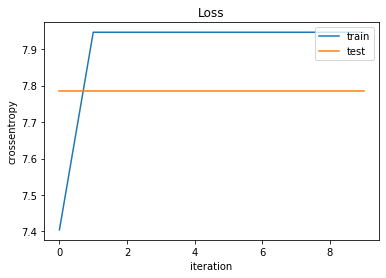

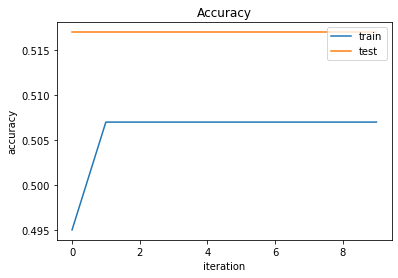

In [29]:
# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

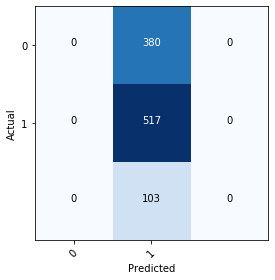

In [30]:
plot_confusion_matrix(model_cnn, X_test_2d, Y_test, range(0, 2))

In [31]:
# Build Mode3
model_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], X_train_2d.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_hidden = Dense(128, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        4128      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
__________

In [32]:
# Optimization Method
# es = EarlyStopping(mode='auto')
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [33]:
# Train
model_history = model_cnn.fit(X_train_2d, Y_train, validation_data=(X_test_2d, Y_test), epochs=10, batch_size=256, verbose=2)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 18s - loss: 0.9785 - acc: 0.4760 - val_loss: 0.9410 - val_acc: 0.4990
Epoch 2/10
 - 16s - loss: 0.9392 - acc: 0.5230 - val_loss: 0.9144 - val_acc: 0.5230
Epoch 3/10
 - 16s - loss: 0.9205 - acc: 0.5500 - val_loss: 0.9014 - val_acc: 0.5440
Epoch 4/10
 - 15s - loss: 0.9132 - acc: 0.5447 - val_loss: 0.9014 - val_acc: 0.5530
Epoch 5/10
 - 15s - loss: 0.8958 - acc: 0.5663 - val_loss: 0.8838 - val_acc: 0.5590
Epoch 6/10
 - 16s - loss: 0.8779 - acc: 0.5810 - val_loss: 0.8760 - val_acc: 0.5710
Epoch 7/10
 - 15s - loss: 0.8625 - acc: 0.5843 - val_loss: 0.8832 - val_acc: 0.5560
Epoch 8/10
 - 16s - loss: 0.8578 - acc: 0.5803 - val_loss: 0.8932 - val_acc: 0.5470
Epoch 9/10
 - 16s - loss: 0.8450 - acc: 0.5950 - val_loss: 0.8643 - val_acc: 0.5560
Epoch 10/10
 - 15s - loss: 0.8203 - acc: 0.6113 - val_loss: 0.8522 - val_acc: 0.5790


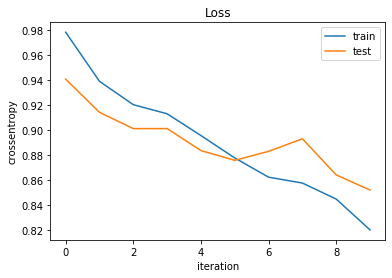

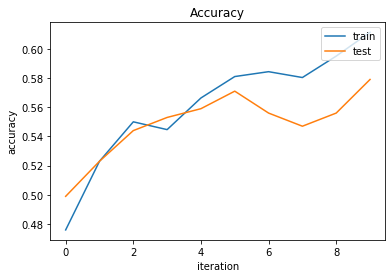

In [34]:
# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

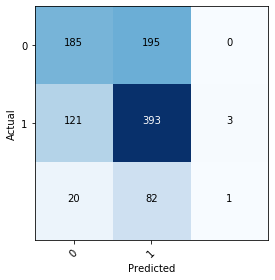

In [35]:
plot_confusion_matrix(model_cnn, X_test_2d, Y_test, range(0, 2))

In [36]:
# Build Mode4
model_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], X_train_2d.shape[3]))
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_hidden = Dense(128, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 8)         40        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        528       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 32)          0         
__________

In [37]:
# Optimization Method
# es = EarlyStopping(mode='auto')
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [38]:
# Train
model_history = model_cnn.fit(X_train_2d, Y_train, validation_data=(X_test_2d, Y_test), epochs=10, batch_size=256, verbose=2)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 12s - loss: 0.9772 - acc: 0.4850 - val_loss: 0.9344 - val_acc: 0.5170
Epoch 2/10
 - 10s - loss: 0.9472 - acc: 0.5010 - val_loss: 0.9211 - val_acc: 0.5630
Epoch 3/10
 - 10s - loss: 0.9367 - acc: 0.5160 - val_loss: 0.9272 - val_acc: 0.5570
Epoch 4/10
 - 10s - loss: 0.9272 - acc: 0.5363 - val_loss: 0.9217 - val_acc: 0.5190
Epoch 5/10
 - 10s - loss: 0.9139 - acc: 0.5370 - val_loss: 0.9076 - val_acc: 0.5380
Epoch 6/10
 - 10s - loss: 0.8927 - acc: 0.5530 - val_loss: 0.8788 - val_acc: 0.5740
Epoch 7/10
 - 11s - loss: 0.8748 - acc: 0.5597 - val_loss: 0.8813 - val_acc: 0.5450
Epoch 8/10
 - 10s - loss: 0.8592 - acc: 0.5700 - val_loss: 0.8654 - val_acc: 0.5570
Epoch 9/10
 - 10s - loss: 0.8450 - acc: 0.5843 - val_loss: 0.8581 - val_acc: 0.5720
Epoch 10/10
 - 10s - loss: 0.8219 - acc: 0.6007 - val_loss: 0.8470 - val_acc: 0.5940


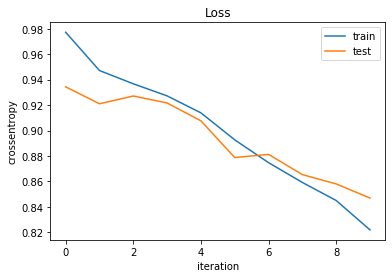

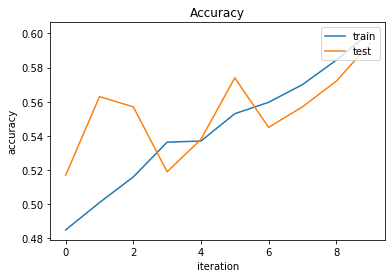

In [39]:
# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

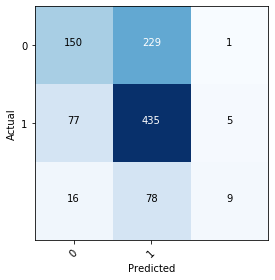

In [40]:
plot_confusion_matrix(model_cnn, X_test_2d, Y_test, range(0, 2))

In [41]:
# Build Mode5
model_input = Input(shape=(X_train_2d.shape[1], X_train_2d.shape[2], X_train_2d.shape[3]))
model_hidden = Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu')(model_input)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Conv2D(16, kernel_size=(2, 2), padding='same', activation='relu')(model_hidden)
model_hidden = MaxPooling2D((2, 2))(model_hidden)
model_hidden = Flatten()(model_hidden)
model_hidden = Dense(2048, activation='relu')(model_hidden)
model_hidden = Dense(1024, activation='relu')(model_hidden)
model_hidden = Dense(512, activation='relu')(model_hidden)
model_output = Dense(Y_train.shape[1], activation='softmax')(model_hidden)
model_cnn = Model(model_input, model_output)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        160       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 16)        2064      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 2048)              8390656   
__________

In [42]:
# Optimization Method
# es = EarlyStopping(mode='auto')
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [43]:
# Train
model_history = model_cnn.fit(X_train_2d, Y_train, validation_data=(X_test_2d, Y_test), epochs=10, batch_size=256, verbose=2)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 44s - loss: 1.2131 - acc: 0.4693 - val_loss: 0.9558 - val_acc: 0.5170
Epoch 2/10
 - 26s - loss: 0.9690 - acc: 0.4863 - val_loss: 0.9506 - val_acc: 0.5170
Epoch 3/10
 - 25s - loss: 0.9617 - acc: 0.5070 - val_loss: 0.9467 - val_acc: 0.5170
Epoch 4/10
 - 26s - loss: 0.9568 - acc: 0.5107 - val_loss: 0.9248 - val_acc: 0.5500
Epoch 5/10
 - 24s - loss: 0.9293 - acc: 0.5383 - val_loss: 0.9227 - val_acc: 0.5120
Epoch 6/10
 - 24s - loss: 0.9070 - acc: 0.5570 - val_loss: 0.8851 - val_acc: 0.5600
Epoch 7/10
 - 24s - loss: 0.8872 - acc: 0.5703 - val_loss: 0.8802 - val_acc: 0.5610
Epoch 8/10
 - 24s - loss: 0.8710 - acc: 0.5803 - val_loss: 0.8814 - val_acc: 0.5510
Epoch 9/10
 - 24s - loss: 0.8711 - acc: 0.5813 - val_loss: 0.8678 - val_acc: 0.5790
Epoch 10/10
 - 24s - loss: 0.8389 - acc: 0.6063 - val_loss: 0.8716 - val_acc: 0.5690


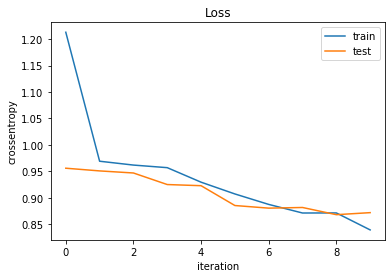

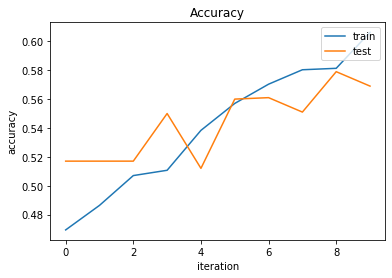

In [44]:
# Validation: Curve Plotting
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

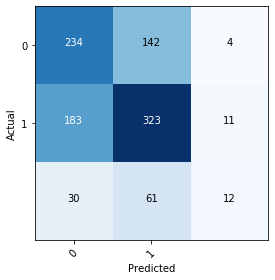

In [45]:
plot_confusion_matrix(model_cnn, X_test_2d, Y_test, range(0, 2))